# Fast Moving Consumer Goods Sales Forecast - Part V

# Intermediate Machine Learning

Last week you learned how to: 
- Tackle data types often found in real-world datasets (**categorical variables**)
- Design **pipelines** to improve the quality of your machine learning code
- Use advanced techniques for model validation (**cross-validation**)

Today you will accelerate your machine learning expertise by learning how to:
- Build state-of-the-art emsemble models with gradient boosted trees (**XGBoost**)
- Avoid common and important data science mistakes (**leakage**).

You will apply your knowledge with data about [weekly retail sales at Walmart stores](https://www.kaggle.com/datasets/rutuspatel/walmart-dataset-retail). The example Walmart Retail dataset is at the file path **`Walmart_Store_sales.csv`**.

You will use different explanatory variables to forecast FMCG weekly sales.  

## Setting Up the Workspace

In [ ]:
# Install packages
#!pip install pandas
#!pip install xgboost

In [ ]:
# Import packages
import pandas as pd
from datetime import datetime

#import matplotlib.pyplot as plt
#import numpy as np 
#import seaborn as sns 

# Import required sklearn modules --------
# Split X and y into training and testing sets
from sklearn.model_selection import train_test_split

# Perform cross validation
from sklearn.model_selection import cross_val_score  

# Import the preprocessing class
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Impute values
from sklearn.impute import SimpleImputer 

# Create pipelines
from sklearn.pipeline import Pipeline 
#from sklearn.pipeline import make_pipeline

# Transform columns
from sklearn.compose import ColumnTransformer 

# Import the model class
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier 

# Import the metrics class
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_absolute_percentage_error 
from sklearn.metrics import mean_squared_error 

# Configures sklearn to display pipeline diagrams
from sklearn import set_config
set_config(display="diagram")

# Import required xgboost modules --------
from xgboost import XGBRegressor

## Loading the Data

In [ ]:
#import pandas as pd # --> DONE UPFRONT (see top section "Setting Up the Workspace")
#from sklearn.model_selection import train_test_split # --> DONE UPFRONT (see top section "Setting Up the Workspace")

# Load data
walmart_file_path = 'https://www.dropbox.com/s/ns7envvzoqyypui/Walmart_Store_sales.csv?dl=1'
#data = pd.read_csv(walmart_file_path, dtype={'Store' : 'category'}) 
# read the data and store data in DataFrame titled walmart_data
# Parse date column from day-month-year into Pandas 
walmart_data = pd.read_csv(walmart_file_path,parse_dates=['Date'], date_parser=lambda x: datetime.strptime(x, '%d-%m-%Y').date()) 
walmart_data = walmart_data.sort_values(['Date','Store']).reset_index().drop('index',axis=1)
walmart_data.Store = walmart_data.Store.astype('category')

results_table = []

# Select target and predictors
y = walmart_data.Weekly_Sales
#walmart_features = ['Fuel_Price', 'Unemployment', 'CPI', 'Temperature', 'Holiday_Flag']
#X = data[walmart_features]
X = walmart_data.drop(['Weekly_Sales'], axis=1)

# Split data into training and validation subsets, for both features and target
# The split is based on a random number generator. 
# Supplying a numeric value to the random_state argument guarantees we get the same split every time we run this script.
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, shuffle=False,
                                                                random_state=123)

### Inspect the Features in the Training Data Subset

In [ ]:
X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5148 entries, 0 to 5147
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         5148 non-null   category      
 1   Date          5148 non-null   datetime64[ns]
 2   Holiday_Flag  5148 non-null   int64         
 3   Temperature   5148 non-null   float64       
 4   Fuel_Price    5148 non-null   float64       
 5   CPI           5148 non-null   float64       
 6   Unemployment  5148 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(4), int64(1)
memory usage: 288.0 KB


In [ ]:
X_train_full.head()

,Store,Date,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,0,42.31,2.572,211.096358,8.106
1,2,2010-02-05,0,40.19,2.572,210.752605,8.324
2,3,2010-02-05,0,45.71,2.572,214.424881,7.368
3,4,2010-02-05,0,43.76,2.598,126.442065,8.623
4,5,2010-02-05,0,39.70,2.572,211.653972,6.566


In [ ]:
X_train_full.tail()

,Store,Date,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
5143,14,2012-04-13,0,51.83,4.044,190.759596,8.567
5144,15,2012-04-13,0,43.52,4.187,137.868000,8.150
5145,16,2012-04-13,0,45.83,3.901,197.780931,6.169
5146,17,2012-04-13,0,46.94,3.833,131.108000,6.235
5147,18,2012-04-13,0,47.75,4.025,137.868000,8.304


In [ ]:
X_train_full.describe(datetime_is_numeric=True).T

,count,mean,min,25%,50%,75%,max,std
Date,5148,2011-03-08 21:46:34.405594624,2010-02-05 00:00:00,2010-08-20 00:00:00,2011-03-11 00:00:00,2011-09-23 00:00:00,2012-04-13 00:00:00,NaN
Holiday_Flag,5148.0,0.078671,0.0,0.0,0.0,0.0,1.0,0.269251
Temperature,5148.0,57.931014,-2.06,44.42,58.7,72.02,100.14,18.788346
Fuel_Price,5148.0,3.260448,2.472,2.837,3.236,3.644,4.294,0.446567
CPI,5148.0,170.536597,126.064,131.686,182.551954,211.406287,225.256244,38.923927
Unemployment,5148.0,8.179414,4.125,7.1805,8.021,8.625,14.313,1.879173


### Inspect the Features in the Validation Data Subset

In [ ]:
X_valid_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1287 entries, 5148 to 6434
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         1287 non-null   category      
 1   Date          1287 non-null   datetime64[ns]
 2   Holiday_Flag  1287 non-null   int64         
 3   Temperature   1287 non-null   float64       
 4   Fuel_Price    1287 non-null   float64       
 5   CPI           1287 non-null   float64       
 6   Unemployment  1287 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(4), int64(1)
memory usage: 73.0 KB


In [ ]:
X_valid_full.head()

,Store,Date,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
5148,19,2012-04-13,0,44.42,4.187,137.868000,8.150
5149,20,2012-04-13,0,45.68,4.044,214.312703,7.139
5150,21,2012-04-13,0,69.03,3.891,221.148403,6.891
5151,22,2012-04-13,0,49.89,4.025,141.843393,7.671
5152,23,2012-04-13,0,41.81,4.025,137.868000,4.125


In [ ]:
X_valid_full.tail()

,Store,Date,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
6430,41,2012-10-26,0,41.80,3.686,199.219532,6.195
6431,42,2012-10-26,0,70.50,4.301,131.193097,6.943
6432,43,2012-10-26,0,69.17,3.506,214.741539,8.839
6433,44,2012-10-26,0,46.97,3.755,131.193097,5.217
6434,45,2012-10-26,0,58.85,3.882,192.308899,8.667


In [ ]:
X_valid_full.describe(datetime_is_numeric=True).T

,count,mean,min,25%,50%,75%,max,std
Date,1287,2012-07-21 08:53:42.377622272,2012-04-13 00:00:00,2012-06-01 00:00:00,2012-07-20 00:00:00,2012-09-07 00:00:00,2012-10-26 00:00:00,NaN
Holiday_Flag,1287.0,0.034965,0.0,0.0,0.0,0.0,1.0,0.183763
Temperature,1287.0,71.594856,36.9,64.255,72.9,80.53,100.07,11.824894
Fuel_Price,1287.0,3.751242,3.187,3.5795,3.73,3.921,4.468,0.251284
CPI,1287.0,175.745581,130.683,137.923067,191.00281,221.255812,227.232807,40.792466
Unemployment,1287.0,7.278099,3.879,6.17,7.139,8.253,11.627,1.679838


In [ ]:
# Drop columns with missing values (simplest approach)
cols_with_missing = [col for col in X_train_full.columns if X_train_full[col].isnull().any()] 
X_train_full.drop(cols_with_missing, axis=1, inplace=True)
X_valid_full.drop(cols_with_missing, axis=1, inplace=True)

# Select categorical columns
categorical_cols = [cname for cname in X_train_full.select_dtypes('category')]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.select_dtypes(['int64', 'float64'])]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()


In [ ]:
categorical_cols

['Store']

In [ ]:
numerical_cols

['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

---
In this section, you will learn how to build and optimize models with **gradient boosting**.  This method achieves state-of-the-art results on a variety of datasets. 

# 4. Gradient Boosted Trees

Last week, you learned to make predictions with the random forest method, which achieves better performance than a single decision tree simply by averaging the predictions of many decision trees.

We refer to the random forest method as an "ensemble method".  By definition, **ensemble methods** combine the predictions of several models (e.g., several trees, in the case of random forests).  

Next, we'll learn about another ensemble method called gradient boosting.  

## Gradient Boosting

**Gradient boosting** is a method that goes through cycles to iteratively add models into an ensemble.  

It begins by initializing the ensemble with a single model, whose predictions can be pretty naive.  (Even if its predictions are wildly inaccurate, subsequent additions to the ensemble will address those errors.)

Then, we start the cycle:
- First, we use the current ensemble to generate predictions for each observation in the dataset.  To make a prediction, we add the predictions from all models in the ensemble.  
- These predictions are used to calculate a loss function (like [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error), for instance).
- Then, we use the loss function to fit a new model that will be added to the ensemble.  Specifically, we determine model parameters so that adding this new model to the ensemble will reduce the loss.  (*Side note: The "gradient" in "gradient boosting" refers to the fact that we'll use [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) on the loss function to determine the parameters in this new model.*)
- Finally, we add the new model to ensemble, and ...
- ... repeat!

![boosting](https://i.imgur.com/MvCGENh.png)


## Example

We begin by loading the training and validation data in `X_train`, `X_valid`, `y_train`, and `y_valid`. 

In [ ]:
X_train_xgb = X_train.copy()
X_valid_xgb = X_valid.copy()

In this example, you'll work with the XGBoost library.  **XGBoost** stands for **extreme gradient boosting**, which is an implementation of gradient boosting with several additional features focused on performance and speed.  (_Scikit-learn has another version of gradient boosting, but XGBoost has some technical advantages._) 

In the next code cell, we import the scikit-learn API for XGBoost ([`xgboost.XGBRegressor`](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)).  This allows us to build and fit a model just as we would in scikit-learn.  As you'll see in the output, the `XGBRegressor` class has many tunable parameters -- you'll learn about those soon!

In [ ]:
#from xgboost import XGBRegressor


X_train_xgb['Store'] = X_train_xgb['Store'].astype('int')
X_valid_xgb['Store'] = X_valid_xgb['Store'].astype('int')

my_model = XGBRegressor(n_estimators=500)
my_model.fit(X_train_xgb, y_train)

[19:45:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=500)

We also make predictions and evaluate the model.

In [ ]:
#from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error # --> DONE UPFRONT (see top section "Setting Up the Workspace")

predictions = my_model.predict(X_valid_xgb)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))
results_table.append(('XGB n_estimators=500, Manual, Ordinal encoding', mean_absolute_error(predictions, y_valid)))
print('MAPE:', mean_absolute_percentage_error(predictions, y_valid))
print('RMSE:', mean_squared_error(predictions, y_valid,squared=False))

Mean Absolute Error: 93030.76122086246
MAPE: 0.10069135698242729
RMSE: 126268.44962819356


## Parameter Tuning

XGBoost has a few parameters that can dramatically affect accuracy and training speed.  The first parameters you should understand are:

### `n_estimators`
`n_estimators` specifies how many times to go through the modeling cycle described above.  It is equal to the number of models that we include in the ensemble. 

- Too _low_ a value causes _underfitting_, which leads to inaccurate predictions on both training data and test data. 
- Too _high_ a value causes _overfitting_, which causes accurate predictions on training data, but inaccurate predictions on test data (_which is what we care about_). 

Typical values range from 100-1000, though this depends a lot on the `learning_rate` parameter discussed below.

Here is the code to set the number of models in the ensemble:

In [ ]:
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train_xgb, y_train)

predictions = my_model.predict(X_valid_xgb)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))
results_table.append(('XGB n_estimators=1000, Manual, Ordinal encoding', mean_absolute_error(predictions, y_valid)))
print('MAPE:', mean_absolute_percentage_error(predictions, y_valid))
print('RMSE:', mean_squared_error(predictions, y_valid,squared=False))

[19:45:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error: 98406.59482080418
MAPE: 0.1038732340228436
RMSE: 131867.29281295557


### `early_stopping_rounds`

`early_stopping_rounds` offers a way to automatically find the ideal value for `n_estimators`. Early stopping causes the model to stop iterating when the validation score stops improving, even if we aren't at the hard stop for `n_estimators`.  It's smart to set a high value for `n_estimators` and then use `early_stopping_rounds` to find the optimal time to stop iterating.

Since random chance sometimes causes a single round where validation scores don't improve, you need to specify a number for how many rounds of straight deterioration to allow before stopping.  Setting `early_stopping_rounds=5` is a reasonable choice.  In this case, we stop after 5 straight rounds of deteriorating validation scores.

When using `early_stopping_rounds`, you also need to set aside some data for calculating the validation scores - this is done by setting the `eval_set` parameter.  

We can modify the example above to include early stopping:

In [ ]:

my_model = XGBRegressor(n_estimators=1000, early_stopping_rounds=5)
my_model.fit(X_train_xgb, y_train, 
             eval_set=[(X_valid_xgb, y_valid)],
             verbose=False)

predictions = my_model.predict(X_valid_xgb)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))
results_table.append(('XGB n_estimators=1000, early_stopping_rounds=5, Manual, Ordinal encoding', mean_absolute_error(predictions, y_valid)))
print('MAPE:', mean_absolute_percentage_error(predictions, y_valid))
print('RMSE:', mean_squared_error(predictions, y_valid,squared=False))

[19:45:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error: 98406.59482080418
MAPE: 0.1038732340228436
RMSE: 131867.29281295557


If you later want to fit a model with all of your data, set `n_estimators` to whatever value you found to be optimal when run with early stopping.

### `learning_rate`

Instead of getting predictions by simply adding up the predictions from each component model, we can multiply the predictions from each model by a small number (known as the **learning rate**) before adding them in.  

This means each tree we add to the ensemble helps us less.  So, we can set a higher value for `n_estimators` without overfitting.  If we use early stopping, the appropriate number of trees will be determined automatically.

In general, a small learning rate and large number of estimators will yield more accurate XGBoost models, though it will also take the model longer to train since it does more iterations through the cycle.  As default, XGBoost sets `learning_rate=0.1`.

Modifying the example above to change the learning rate yields the following code:

In [ ]:

my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping_rounds=5)
my_model.fit(X_train_xgb, y_train, 
             eval_set=[(X_valid_xgb, y_valid)], 
             verbose=False)

predictions = my_model.predict(X_valid_xgb)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))
results_table.append(('XGB n_estimators=1000, learning_rate=0.05, early_stopping_rounds=5, Manual, Ordinal encoding', mean_absolute_error(predictions, y_valid)))
print('MAPE:', mean_absolute_percentage_error(predictions, y_valid))
print('RMSE:', mean_squared_error(predictions, y_valid,squared=False))

[19:46:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error: 92458.01192307692
MAPE: 0.10122954175849284
RMSE: 122772.39431737462


### `n_jobs`
On larger datasets where runtime is a consideration, you can use parallelism to build your models faster.  It's common to set the parameter `n_jobs` equal to the number of cores on your machine.  On smaller datasets, this won't help. 

The resulting model won't be any better, so micro-optimizing for fitting time is typically nothing but a distraction. But, it's useful in large datasets where you would otherwise spend a long time waiting during the `fit` command.

Here's the modified example:

In [ ]:

my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
my_model.fit(X_train_xgb, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid_xgb, y_valid)], 
             verbose=False)

predictions = my_model.predict(X_valid_xgb)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))
results_table.append(('XGB n_estimators=1000, n_jobs = 4, learning_rate=0.05, early_stopping_rounds=5, Manual, Ordinal encoding', mean_absolute_error(predictions, y_valid)))
print('MAPE:', mean_absolute_percentage_error(predictions, y_valid))
print('RMSE:', mean_squared_error(predictions, y_valid,squared=False))

[19:46:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error: 104491.83789821289
MAPE: 0.1187387199546035
RMSE: 138409.65406531026


## XGBoost with Pipelines and One-Hot Encoding of Categorical Values

In [ ]:
#from sklearn.pipeline import Pipeline # --> DONE UPFRONT (see top section "Setting Up the Workspace")
#from sklearn.impute import SimpleImputer # --> DONE UPFRONT (see top section "Setting Up the Workspace")
#from sklearn.preprocessing import StandardScaler # --> DONE UPFRONT (see top section "Setting Up the Workspace")
#from sklearn.preprocessing import OneHotEncoder # --> DONE UPFRONT (see top section "Setting Up the Workspace")
#from sklearn.compose import ColumnTransformer # --> DONE UPFRONT (see top section "Setting Up the Workspace")

# Select categorical columns
categorical_cols = ['Store']

# Select numerical columns
#numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64'] and cname not in categorical_cols]

# Preprocessing for numerical data
#numerical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='constant')),
#    ('scaler', StandardScaler())
#])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
#        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],remainder='passthrough')

my_model = XGBRegressor(n_estimators=1000)

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', my_model)
                             ])

my_pipeline.fit(X_train, y_train)

[19:46:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Store'])])),
                ('model', XGBRegressor(n_estimators=1000))])

In [ ]:
# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid_xgb)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE: With Store id as category', score)
print('MAPE: With Store id as category', mean_absolute_percentage_error(y_valid, preds))
results_table.append(('XGB n_estimators=1000, Pipeline, Onehot encoding. X Train/Train', score))
print('RMSE: With Store id as category', mean_squared_error(y_valid, preds,squared=False))

MAE: With Store id as category 73247.76648552837
MAPE: With Store id as category 0.07630015177068024
RMSE: With Store id as category 104454.6051834407


In [ ]:
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates negative MAE
scores = -1 * cross_val_score(my_pipeline, X.drop('Date',axis=1), y,
                              cv=5,verbose=10,
                              scoring='neg_mean_absolute_error')
for i, score in enumerate(scores):
  results_table.append((f'XGB n_estimators=1000, Pipeline, Onehot encoding. Cross Validation fold {i}', score))

results_table.append((f'XGB n_estimators=1000, Pipeline, Onehot encoding. Cross Validation mean', scores.mean()))

print("MAE scores:\n", scores)
print("Mean MAE score:\n", scores.mean())

[CV] START .....................................................................
[19:46:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .......................... score: (test=-174688.880) total time=   7.4s
[CV] START .....................................................................
[19:46:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s


[CV] END .......................... score: (test=-141625.289) total time=   7.0s
[CV] START .....................................................................
[19:46:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.4s remaining:    0.0s


[CV] END ........................... score: (test=-61805.380) total time=   7.5s
[CV] START .....................................................................
[19:46:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.9s remaining:    0.0s


[CV] END .......................... score: (test=-122956.543) total time=   6.6s
[CV] START .....................................................................
[19:46:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   28.5s remaining:    0.0s


[CV] END ........................... score: (test=-73247.766) total time=   7.6s
MAE scores:
 [174688.87984557 141625.28942599  61805.37963627 122956.54324592
  73247.76648553]
Mean MAE score:
 114864.77172785548


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.1s finished


## Take-away: Gradient Boosted Trees

[XGBoost](https://xgboost.readthedocs.io/en/latest/) *is a leading software library for working with standard tabular data (the type of data you store in Pandas DataFrames, as opposed to more exotic types of data like images and videos).  With careful parameter tuning, you can train highly accurate models.* 

---
In this section, you will learn what **data leakage** is and how to prevent it. If you don't know how to prevent it, leakage will come up frequently, and it will ruin your models in subtle and dangerous ways.  So, this is one of the most **important** concepts for practicing data scientists.


# 5. Data Leakage

**Data leakage** (or **leakage**) happens when your training data contains information about the target, but similar data will not be available when the model is used for prediction. This leads to high performance on the training set (and possibly even the validation data), but the model will perform poorly in production.

In other words, leakage causes a model to look accurate until you start making decisions with the model, and then the model becomes very inaccurate. 

There are two main types of leakage: **Target leakage** and **Train-test contamination.**

## Target leakage

**Target leakage** occurs when your predictors include data that will not be available at the time you make predictions. It is important to think about target leakage in terms of the _timing or chronological order_ that data becomes available, not merely whether a feature helps make good predictions.

Since validation data comes from the same source as training data, the pattern will repeat itself in validation, and the model will have great validation (or cross-validation) scores. But the model will be very inaccurate when subsequently deployed in the real world.

To prevent this type of data leakage, any variable updated (or created) after the target value is realized should be excluded. 

![leakydata](https://i.imgur.com/y7hfTYe.png)

## Train-Test Contamination

A different type of leak occurs when you aren't careful to distinguish training data from validation data.  

Recall that validation is meant to be a measure of how the model does on data that it hasn't considered before.  You can corrupt this process in subtle ways if the validation data affects the preprocessing behavior.  This is sometimes called **train-test contamination**. 

For example, imagine you run preprocessing (like fitting an imputer for missing values) before calling [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).  The end result?  Your model may get good validation scores, giving you great confidence in it, but perform poorly when you deploy it to make decisions.

After all, you incorporated data from the validation or test data into how you make predictions, so the may do well on that particular data even if it can't generalize to new data. This problem becomes even more subtle (and more dangerous) when you do more complex feature engineering.

If your validation is based on a simple train-test split, exclude the validation data from any type of *fitting*, including the fitting of preprocessing steps.  This is easier if you use scikit-learn pipelines.  When using cross-validation, it's even more critical that you do your preprocessing inside the pipeline!

## Example

In this example, you will see the effect of removing target leakage.


In [ ]:
#import pandas as pd # --> DONE UPFRONT (see top section "Setting Up the Workspace")
#from sklearn.model_selection import train_test_split # --> DONE UPFRONT (see top section "Setting Up the Workspace")

# Load data
walmart_file_path = 'https://www.dropbox.com/s/ns7envvzoqyypui/Walmart_Store_sales.csv?dl=1'
#data = pd.read_csv(walmart_file_path, dtype={'Store' : 'category'}) 
# read the data and store data in DataFrame titled walmart_data
# Parse date column from day-month-year into Pandas 
walmart_data = pd.read_csv(walmart_file_path,parse_dates=['Date'], date_parser=lambda x: datetime.strptime(x, '%d-%m-%Y').date()) 
walmart_data = walmart_data.sort_values(['Date','Store'])
walmart_data.Store = walmart_data.Store.astype('category')

# Select target and predictors
y = walmart_data.Weekly_Sales
#walmart_features = ['Fuel_Price', 'Unemployment', 'CPI', 'Temperature', 'Holiday_Flag']
#X = data[walmart_features]
X = walmart_data.drop(['Weekly_Sales'], axis=1)

In [ ]:
# Select categorical columns
categorical_cols = [cname for cname in X.select_dtypes('category')]
categorical_cols

['Store']

In [ ]:
# Select numerical columns
numerical_cols = [cname for cname in X.select_dtypes(['int64', 'float64'])]
numerical_cols

['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

In [ ]:
print("Number of rows in the dataset:", X.shape[0])

Number of rows in the dataset: 6435


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6435 entries, 0 to 6434
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   category      
 1   Date          6435 non-null   datetime64[ns]
 2   Holiday_Flag  6435 non-null   int64         
 3   Temperature   6435 non-null   float64       
 4   Fuel_Price    6435 non-null   float64       
 5   CPI           6435 non-null   float64       
 6   Unemployment  6435 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(4), int64(1)
memory usage: 359.6 KB


In [ ]:
X.head()

,Store,Date,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,0,42.31,2.572,211.096358,8.106
143,2,2010-02-05,0,40.19,2.572,210.752605,8.324
286,3,2010-02-05,0,45.71,2.572,214.424881,7.368
429,4,2010-02-05,0,43.76,2.598,126.442065,8.623
572,5,2010-02-05,0,39.70,2.572,211.653972,6.566


Since this is a small dataset, we will use cross-validation to ensure accurate measures of model quality.

In [ ]:
#from sklearn.pipeline import make_pipeline # --> DONE UPFRONT (see top section "Setting Up the Workspace")
#from sklearn.ensemble import RandomForestRegressor # --> DONE UPFRONT (see top section "Setting Up the Workspace")
#from sklearn.model_selection import cross_val_score # --> DONE UPFRONT (see top section "Setting Up the Workspace")


categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
#        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],remainder='passthrough')

rf_model = RandomForestRegressor(n_estimators=1000, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', rf_model)
                             ])

cv_scores = -1*cross_val_score(rf_pipeline, X.drop('Date',axis=1), y, 
                            cv=5, error_score='raise', verbose =10,
                            scoring='neg_mean_absolute_error')

for i, score in enumerate(cv_scores):
  results_table.append((f'RF n_estimators=1000, Onehot encoding. Leaky. Cross Validation fold {i}', score))

results_table.append((f'RF n_estimators=1000, Onehot encoding. Leaky. Cross Validation mean', cv_scores.mean()))
print(f"Cross-validation MAE: {cv_scores.mean()*-1}")

xgb_model = XGBRegressor(n_estimators=1000)

xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', xgb_model)
                             ])

cv_scores = -1*cross_val_score(xgb_pipeline, X.drop('Date',axis=1), y, 
                            cv=5, error_score='raise', verbose =10,
                            scoring='neg_mean_absolute_error')

for i, score in enumerate(cv_scores):
  results_table.append((f'XGB n_estimators=1000, Onehot encoding. Leaky. Cross Validation fold {i}', score))

results_table.append((f'XGB n_estimators=1000, Onehot encoding. Leaky. Cross Validation mean', cv_scores.mean()))


[CV] START .....................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .......................... score: (test=-189002.177) total time=  43.4s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   43.5s remaining:    0.0s


[CV] END .......................... score: (test=-147319.425) total time=  43.4s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s


[CV] END ........................... score: (test=-59286.575) total time=  43.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.2min remaining:    0.0s


[CV] END .......................... score: (test=-117973.593) total time=  43.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.9min remaining:    0.0s


[CV] END ........................... score: (test=-88346.307) total time=  42.5s
Cross-validation MAE: -120385.6154321852
[CV] START .....................................................................
[19:50:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .......................... score: (test=-174688.880) total time=   7.5s
[CV] START .....................................................................
[19:50:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s


[CV] END .......................... score: (test=-141625.289) total time=   6.8s
[CV] START .....................................................................
[19:50:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.3s remaining:    0.0s


[CV] END ........................... score: (test=-61805.380) total time=   8.3s
[CV] START .....................................................................
[19:50:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.6s remaining:    0.0s


[CV] END .......................... score: (test=-122956.543) total time=   6.6s
[CV] START .....................................................................
[19:51:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   29.2s remaining:    0.0s


[CV] END ........................... score: (test=-73247.766) total time=   7.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.7s finished


We would run a model without target leakage as follows:

In [ ]:
# Drop leaky predictors from dataset
potential_leaks = ['CPI','Unemployment','Fuel_Price']
X2 = X.drop(potential_leaks, axis=1)

# Evaluate the model with leaky predictors removed
cv_scores = -1*cross_val_score(rf_pipeline, X2.drop('Date',axis=1), y, 
                            cv=5, error_score='raise', verbose = 10,
                            scoring='neg_mean_absolute_error')

for i, score in enumerate(cv_scores):
  results_table.append((f'RF n_estimators=1000, Onehot encoding. Not-Leaky. Cross Validation fold {i}', score))

results_table.append((f'RF n_estimators=1000, Onehot encoding. Not-Leaky. Cross Validation mean', cv_scores.mean()))
print(f"Cross-validation MAE: {cv_scores.mean()}")

cv_scores = -1*cross_val_score(xgb_pipeline, X2.drop('Date',axis=1), y, 
                            cv=5, error_score='raise', verbose = 10,
                            scoring='neg_mean_absolute_error')

for i, score in enumerate(cv_scores):
  results_table.append((f'XGB n_estimators=1000, Onehot encoding. Not-Leaky. Cross Validation fold {i}', score))

results_table.append((f'XGB n_estimators=1000, Onehot encoding. Not-Leaky. Cross Validation mean', cv_scores.mean()))
print(f"Cross-validation MAE: {cv_scores.mean()}")

[CV] START .....................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ........................... score: (test=-97515.627) total time=  26.1s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.1s remaining:    0.0s


[CV] END .......................... score: (test=-142228.669) total time=  26.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   52.1s remaining:    0.0s


[CV] END ........................... score: (test=-69405.303) total time=  25.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s


[CV] END .......................... score: (test=-137593.788) total time=  26.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.7min remaining:    0.0s


[CV] END ........................... score: (test=-79411.520) total time=  26.1s
Cross-validation MAE: 105230.98131943765
[CV] START .....................................................................
[19:53:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ........................... score: (test=-88766.835) total time=   6.9s
[CV] START .....................................................................
[19:53:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s


[CV] END .......................... score: (test=-143463.618) total time=   6.0s
[CV] START .....................................................................
[19:53:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.9s remaining:    0.0s


[CV] END ........................... score: (test=-63678.806) total time=   6.8s
[CV] START .....................................................................
[19:53:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.7s remaining:    0.0s


[CV] END .......................... score: (test=-129409.819) total time=   6.0s
[CV] START .....................................................................
[19:53:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   25.7s remaining:    0.0s


[CV] END ........................... score: (test=-70089.831) total time=   6.9s
Cross-validation MAE: 99081.78197027973


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.6s finished


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

cv_scores = -1*cross_val_score(rf_pipeline, X.drop('Date',axis=1), y, cv=TimeSeriesSplit(n_splits=4), scoring='neg_mean_absolute_error', verbose=3)

for i, score in enumerate(cv_scores):
  results_table.append((f'RF n_estimators=1000, Onehot encoding. Leaky. Time Series Cross Validation fold {i}', score))
results_table.append((f'RF n_estimators=1000, Onehot encoding. Leaky. Time Series Cross Validation mean', cv_scores.mean()))

cv_scores = -1*cross_val_score(xgb_pipeline, X.drop('Date',axis=1), y, 
                            cv=TimeSeriesSplit(n_splits=4), error_score='raise', verbose = 10,
                            scoring='neg_mean_absolute_error')

for i, score in enumerate(cv_scores):
  results_table.append((f'XGB n_estimators=1000, Onehot encoding. Leaky. Time Series Cross Validation fold {i}', score))

results_table.append((f'XGB n_estimators=1000, Onehot encoding. Leaky. Time Series Cross Validation mean', cv_scores.mean()))


print (score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .......................... score: (test=-143391.727) total time=  10.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.5s remaining:    0.0s


[CV] END ........................... score: (test=-75594.770) total time=  20.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   30.6s remaining:    0.0s


[CV] END .......................... score: (test=-136998.340) total time=  33.8s
[CV] END ........................... score: (test=-88346.307) total time=  43.9s
[CV] START .....................................................................
[19:55:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .......................... score: (test=-152986.395) total time=   1.8s
[CV] START .....................................................................
[19:55:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] END ........................... score: (test=-85918.146) total time=   3.7s
[CV] START .....................................................................
[19:55:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s


[CV] END .......................... score: (test=-137454.223) total time=   5.6s
[CV] START .....................................................................
[19:55:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.0s remaining:    0.0s


[CV] END ........................... score: (test=-73247.766) total time=   6.8s
73247.76648552837


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   17.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   17.8s finished


In [ ]:
rf_pipeline.fit(X.drop('Date',axis=1).iloc[:5148], y.iloc[:5148])
rf_predictions = rf_pipeline.predict(X.drop('Date',axis=1).iloc[5148:])
print (f"Manual last fold MAE RF: {mean_absolute_error(rf_predictions, y.iloc[5148:])}")
results_table.append(('Manual TimeSeries last fold MAE RF', mean_absolute_error(rf_predictions, y.iloc[5148:])))

xgb_pipeline.fit(X.drop('Date',axis=1).iloc[:5148], y.iloc[:5148])
xgb_predictions = xgb_pipeline.predict(X.drop('Date',axis=1).iloc[5148:])
results_table.append(('Manual TimeSeries last fold MAE XGB', mean_absolute_error(xgb_predictions, y.iloc[5148:])))
print (f"Manual last fold MAE XGB: {mean_absolute_error(xgb_predictions, y.iloc[5148:])}")

Manual last fold MAE RF: 88346.30729523805
[19:56:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Manual last fold MAE XGB: 73247.76648552837


In [ ]:
from sklearn.model_selection import KFold

for i, (train_index, test_index) in enumerate(KFold(n_splits=5).split(X)):
  print (f"\nFold {i}")
  print (f"Train from {train_index[0]} to {train_index[-1]} n={len(train_index)}")
  #print(f"  Train: index={[X.index[x] for x in train_index]}")
  dates_included = sorted(list(set([X.iloc[x].Date for x in train_index])))
  print(f"  Train: from {dates_included[0]} to {dates_included[-1]} dates={dates_included}")
  print (f"Test from {test_index[0]} to {test_index[-1]} n={len(test_index)}")
  #print(f"  Test:  index={[X.index[x] for x in test_index]}")
  dates_included = sorted(list(set([X.iloc[x].Date for x in test_index])))
  print(f"  Test: from {dates_included[0]} to {dates_included[-1]} dates={dates_included}")


Fold 0
Train from 1287 to 6434 n=5148
  Train: from 2010-08-20 00:00:00 to 2012-10-26 00:00:00 dates=[Timestamp('2010-08-20 00:00:00'), Timestamp('2010-08-27 00:00:00'), Timestamp('2010-09-03 00:00:00'), Timestamp('2010-09-10 00:00:00'), Timestamp('2010-09-17 00:00:00'), Timestamp('2010-09-24 00:00:00'), Timestamp('2010-10-01 00:00:00'), Timestamp('2010-10-08 00:00:00'), Timestamp('2010-10-15 00:00:00'), Timestamp('2010-10-22 00:00:00'), Timestamp('2010-10-29 00:00:00'), Timestamp('2010-11-05 00:00:00'), Timestamp('2010-11-12 00:00:00'), Timestamp('2010-11-19 00:00:00'), Timestamp('2010-11-26 00:00:00'), Timestamp('2010-12-03 00:00:00'), Timestamp('2010-12-10 00:00:00'), Timestamp('2010-12-17 00:00:00'), Timestamp('2010-12-24 00:00:00'), Timestamp('2010-12-31 00:00:00'), Timestamp('2011-01-07 00:00:00'), Timestamp('2011-01-14 00:00:00'), Timestamp('2011-01-21 00:00:00'), Timestamp('2011-01-28 00:00:00'), Timestamp('2011-02-04 00:00:00'), Timestamp('2011-02-11 00:00:00'), Timestamp('20

In [ ]:
for i, (train_index, test_index) in enumerate(TimeSeriesSplit(n_splits=4).split(X)):
  print (f"\nFold {i}")
  print (f"Train from {train_index[0]} to {train_index[-1]} n={len(train_index)}")
  #print(f"  Train: index={[X.index[x] for x in train_index]}")
  dates_included = sorted(list(set([X.iloc[x].Date for x in train_index])))
  print(f"  Train: from {dates_included[0]} to {dates_included[-1]} dates={dates_included}")
  print (f"Test from {test_index[0]} to {test_index[-1]} n={len(test_index)}")
  #print(f"  Test:  index={[X.index[x] for x in test_index]}")
  dates_included = sorted(list(set([X.iloc[x].Date for x in test_index])))
  print(f"  Test: from {dates_included[0]} to {dates_included[-1]} dates={dates_included}")


Fold 0
Train from 0 to 1286 n=1287
  Train: from 2010-02-05 00:00:00 to 2010-08-20 00:00:00 dates=[Timestamp('2010-02-05 00:00:00'), Timestamp('2010-02-12 00:00:00'), Timestamp('2010-02-19 00:00:00'), Timestamp('2010-02-26 00:00:00'), Timestamp('2010-03-05 00:00:00'), Timestamp('2010-03-12 00:00:00'), Timestamp('2010-03-19 00:00:00'), Timestamp('2010-03-26 00:00:00'), Timestamp('2010-04-02 00:00:00'), Timestamp('2010-04-09 00:00:00'), Timestamp('2010-04-16 00:00:00'), Timestamp('2010-04-23 00:00:00'), Timestamp('2010-04-30 00:00:00'), Timestamp('2010-05-07 00:00:00'), Timestamp('2010-05-14 00:00:00'), Timestamp('2010-05-21 00:00:00'), Timestamp('2010-05-28 00:00:00'), Timestamp('2010-06-04 00:00:00'), Timestamp('2010-06-11 00:00:00'), Timestamp('2010-06-18 00:00:00'), Timestamp('2010-06-25 00:00:00'), Timestamp('2010-07-02 00:00:00'), Timestamp('2010-07-09 00:00:00'), Timestamp('2010-07-16 00:00:00'), Timestamp('2010-07-23 00:00:00'), Timestamp('2010-07-30 00:00:00'), Timestamp('2010-

This MAE is quite a bit higher, which might be disappointing.  However, we can expect it to be right about 80% of the time when used on new applications, whereas the leaky model would likely do much worse than that (in spite of its higher apparent score in cross-validation).

## Take-away: Data Leakage
*Data leakage can be multi-million dollar mistake in many data science applications.  Careful separation of training and validation data can prevent train-test contamination, and pipelines can help implement this separation.  Likewise, a combination of caution, common sense, and data exploration can help identify target leakage.*


In [ ]:
results_table = pd.DataFrame(results_table, columns=['Description', 'MAE'])

In [ ]:
results_table

,Description,MAE
0,"XGB n_estimators=500, Manual, Ordinal encoding",93030.761221
1,"XGB n_estimators=1000, Manual, Ordinal encoding",98406.594821
2,"XGB n_estimators=1000, early_stopping_rounds=5...",98406.594821
3,"XGB n_estimators=1000, learning_rate=0.05, ear...",92458.011923
4,"XGB n_estimators=1000, n_jobs = 4, learning_ra...",104491.837898
5,"XGB n_estimators=1000, Pipeline, Onehot encodi...",73247.766486
6,"XGB n_estimators=1000, Pipeline, Onehot encodi...",174688.879846
7,"XGB n_estimators=1000, Pipeline, Onehot encodi...",141625.289426
8,"XGB n_estimators=1000, Pipeline, Onehot encodi...",61805.379636
9,"XGB n_estimators=1000, Pipeline, Onehot encodi...",122956.543246


|index|Description|MAE|
|---|---|---|
|26|RF n\_estimators=1000, Onehot encoding\. Leaky\. Cross Validation fold 2|59286\.57479363592|
|8|RF, Cross validation, One-hot encoding fold2|59617\.094410411824|
|20|XGB n\_estimators=1000, Pipeline, Onehot encoding\. Cross Validation fold 2|61805\.379636266516|
|32|XGB n\_estimators=1000, Onehot encoding\. Leaky\. Cross Validation fold 2|61805\.379636266516|
|58|Manual TimeSeries last fold MAE RF|63055\.82034367543|
|44|XGB n\_estimators=1000, Onehot encoding\. Not-Leaky\. Cross Validation fold 2|63678\.80619755244|
|38|RF n\_estimators=1000, Onehot encoding\. Not-Leaky\. Cross Validation fold 2|69405\.3028619949|
|46|XGB n\_estimators=1000, Onehot encoding\. Not-Leaky\. Cross Validation fold 4|70089\.83142919581|
|59|Manual TimeSeries last fold MAE XGB|70929\.17064015858|
|17|XGB n\_estimators=1000, Pipeline, Onehot encoding\. X Train/Train|73247\.76648552837|
|22|XGB n\_estimators=1000, Pipeline, Onehot encoding\. Cross Validation fold 4|73247\.76648552837|
|34|XGB n\_estimators=1000, Onehot encoding\. Leaky\. Cross Validation fold 4|73247\.76648552837|
|56|XGB n\_estimators=1000, Onehot encoding\. Leaky\. Time Series Cross Validation fold 3|73247\.76648552837|
|49|RF n\_estimators=1000, Onehot encoding\. Leaky\. Time Series Cross Validation fold 1|75594\.77020889611|
|40|RF n\_estimators=1000, Onehot encoding\. Not-Leaky\. Cross Validation fold 4|79411\.51963393504|
|54|XGB n\_estimators=1000, Onehot encoding\. Leaky\. Time Series Cross Validation fold 1|85918\.14635173854|
|28|RF n\_estimators=1000, Onehot encoding\. Leaky\. Cross Validation fold 4|88346\.30729523805|
|51|RF n\_estimators=1000, Onehot encoding\. Leaky\. Time Series Cross Validation fold 3|88346\.30729523805|
|42|XGB n\_estimators=1000, Onehot encoding\. Not-Leaky\. Cross Validation fold 0|88766\.8345789627|
|2|RF, Manual, One Hot Encoding|90743\.75075244748|
|3|RF, Pipeline, One Hot Encoding|90743\.75075244748|
|10|RF, Cross validation, One-hot encoding fold4|90743\.75075244748|
|15|XGB n\_estimators=1000, learning\_rate=0\.05, early\_stopping\_rounds=5, Manual, Ordinal encoding|92458\.01192307692|
|12|XGB n\_estimators=500, Manual, Ordinal encoding|93030\.76122086246|
|36|RF n\_estimators=1000, Onehot encoding\. Not-Leaky\. Cross Validation fold 0|97515\.62715892735|
|13|XGB n\_estimators=1000, Manual, Ordinal encoding|98406\.59482080418|
|14|XGB n\_estimators=1000, early\_stopping\_rounds=5, Manual, Ordinal encoding|98406\.59482080418|
|47|XGB n\_estimators=1000, Onehot encoding\. Not-Leaky\. Cross Validation mean|99081\.78197027973|
|1|RF, Manual, Ordinal encoding|102223\.73129355072|
|4|RF, Pipeline, Ordinal Encoding|102223\.73129355072|
|16|XGB n\_estimators=1000, n\_jobs = 4, learning\_rate=0\.05, early\_stopping\_rounds=5, Manual, Ordinal encoding|104491\.83789821289|
|41|RF n\_estimators=1000, Onehot encoding\. Not-Leaky\. Cross Validation mean|105230\.98131943765|
|52|RF n\_estimators=1000, Onehot encoding\. Leaky\. Time Series Cross Validation mean|111082\.78617382306|
|57|XGB n\_estimators=1000, Onehot encoding\. Leaky\. Time Series Cross Validation mean|112401\.63258358829|
|23|XGB n\_estimators=1000, Pipeline, Onehot encoding\. Cross Validation mean|114864\.77172785548|
|35|XGB n\_estimators=1000, Onehot encoding\. Leaky\. Cross Validation mean|114864\.77172785548|
|9|RF, Cross validation, One-hot encoding fold3|117766\.67272898207|
|27|RF n\_estimators=1000, Onehot encoding\. Leaky\. Cross Validation fold 3|117973\.59326459991|
|29|RF n\_estimators=1000, Onehot encoding\. Leaky\. Cross Validation mean|120385\.6154321852|
|11|RF, Cross validation, One-hot encoding mean|121228\.87544759906|
|21|XGB n\_estimators=1000, Pipeline, Onehot encoding\. Cross Validation fold 3|122956\.54324592072|
|33|XGB n\_estimators=1000, Onehot encoding\. Leaky\. Cross Validation fold 3|122956\.54324592072|
|45|XGB n\_estimators=1000, Onehot encoding\. Not-Leaky\. Cross Validation fold 3|129409\.81922688422|
|50|RF n\_estimators=1000, Onehot encoding\. Leaky\. Time Series Cross Validation fold 2|136998\.33970765382|
|55|XGB n\_estimators=1000, Onehot encoding\. Leaky\. Time Series Cross Validation fold 2|137454\.222664627|
|39|RF n\_estimators=1000, Onehot encoding\. Not-Leaky\. Cross Validation fold 3|137593\.78827031766|
|19|XGB n\_estimators=1000, Pipeline, Onehot encoding\. Cross Validation fold 1|141625\.28942599066|
|31|XGB n\_estimators=1000, Onehot encoding\. Leaky\. Cross Validation fold 1|141625\.28942599066|
|37|RF n\_estimators=1000, Onehot encoding\. Not-Leaky\. Cross Validation fold 1|142228\.6686720132|
|48|RF n\_estimators=1000, Onehot encoding\. Leaky\. Time Series Cross Validation fold 0|143391\.72748350422|
|43|XGB n\_estimators=1000, Onehot encoding\. Not-Leaky\. Cross Validation fold 1|143463\.6184188034|
|7|RF, Cross validation, One-hot encoding fold1|147265\.53192167834|
|25|RF n\_estimators=1000, Onehot encoding\. Leaky\. Cross Validation fold 1|147319\.42497627018|
|53|XGB n\_estimators=1000, Onehot encoding\. Leaky\. Time Series Cross Validation fold 0|152986\.3948324592|
|18|XGB n\_estimators=1000, Pipeline, Onehot encoding\. Cross Validation fold 0|174688\.87984557112|
|30|XGB n\_estimators=1000, Onehot encoding\. Leaky\. Cross Validation fold 0|174688\.87984557112|
|24|RF n\_estimators=1000, Onehot encoding\. Leaky\. Cross Validation fold 0|189002\.17683118192|
|6|RF, Cross validation, One-hot encoding fold0|190751\.32742447552|
|0|RF, Manual, without categories|440064\.5559917593|
|5|RF, Pipeline, No categories|440064\.5559917593|

In [ ]:
data = walmart_data.copy()
data['day_of_year'] = data.Date.dt.dayofyear
data['year'] = data.Date.dt.year
data['store+year'] = data['year'].astype('str') + '+' + data['Store'].astype('str')
data.set_index(['Store','year','day_of_year'])['Weekly_Sales']

Store  year  day_of_year
1      2010  36             1643690.90
2      2010  36             2136989.46
3      2010  36              461622.22
4      2010  36             2135143.87
5      2010  36              317173.10
                               ...    
41     2012  300            1316542.59
42     2012  300             514756.08
43     2012  300             587603.55
44     2012  300             361067.07
45     2012  300             760281.43
Name: Weekly_Sales, Length: 6435, dtype: float64

In [ ]:
data

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,day_of_year,year,store+year
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,36,2010,2010+1
143,2,2010-02-05,2136989.46,0,40.19,2.572,210.752605,8.324,36,2010,2010+2
286,3,2010-02-05,461622.22,0,45.71,2.572,214.424881,7.368,36,2010,2010+3
429,4,2010-02-05,2135143.87,0,43.76,2.598,126.442065,8.623,36,2010,2010+4
572,5,2010-02-05,317173.10,0,39.70,2.572,211.653972,6.566,36,2010,2010+5
...,...,...,...,...,...,...,...,...,...,...,...
5862,41,2012-10-26,1316542.59,0,41.80,3.686,199.219532,6.195,300,2012,2012+41
6005,42,2012-10-26,514756.08,0,70.50,4.301,131.193097,6.943,300,2012,2012+42
6148,43,2012-10-26,587603.55,0,69.17,3.506,214.741539,8.839,300,2012,2012+43
6291,44,2012-10-26,361067.07,0,46.97,3.755,131.193097,5.217,300,2012,2012+44


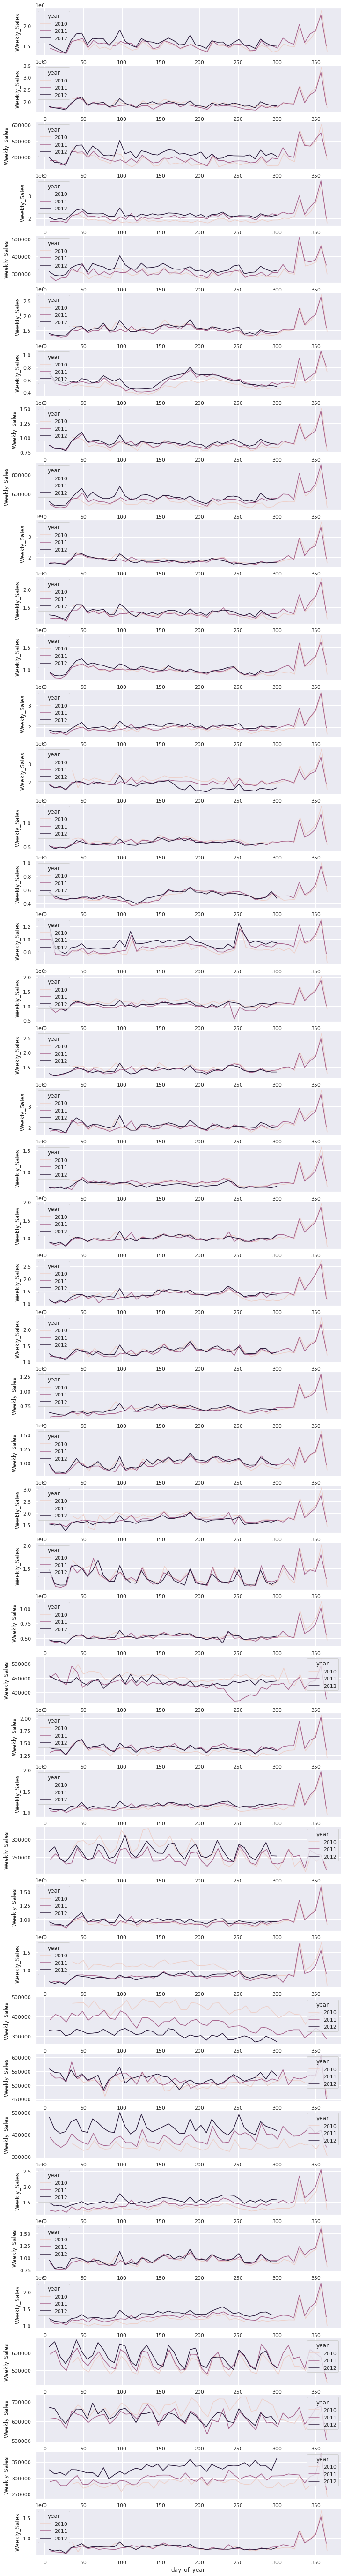

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(11.7,100)})

#fig, axs = plt.subplots(nrows=int((data.Store.nunique()/4)+1),ncols=4)
fig, ax = plt.subplots(data.Store.nunique())

for i, store in enumerate(data.Store.unique()):
    sns.lineplot(data=data[data.Store == store],x='day_of_year',y='Weekly_Sales',hue='year', ax=ax[i])